### Step 1: Problem statement

In this challenge, the ask it to complete the analysis of what sorts of people were likely to survive. In particular, the ask is to apply the tools of machine learning to predict which passengers survived the tragedy.

### Step 2: Collecting data

In this step we will import required libraries and data from csv files.

In [69]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

# Importing Pandas and NumPy
import pandas as pd, numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

In [70]:
# Importing all datasets
TitanicDataTr = pd.read_csv("train.csv")
TitanicDataTs = pd.read_csv("test.csv")

### Step 3: Exploratory data analysis

In this challenge, the ask it to complete the analysis of what sorts of people were likely to survive. In particular, the ask is to apply the tools of machine learning to predict which passengers survived the tragedy.

In [71]:
TitanicDataTr.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


| Variable | Definition | Key |
| --- | --- | --- |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| survival | Survival | 0 = No, 1 = Yes |
| sex | Sex | Male/Female |
| Age | Age in years |  |
| sibsp | # of siblings / spouses aboard the Titanic |  |
| parch | # of parents / children aboard the Titanic |  |
| ticket | Ticket number |  |
| fare | Passenger fare |  |
| cabin | Cabin number |  |
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |	

In [72]:
# we will concatenate the data for easier null treatment and better dummy variable creation
TitanicData=pd.concat([TitanicDataTr, TitanicDataTs], ignore_index=True)

In [73]:
# Extracting the Title from Name.

TitanicData["Title"]=(TitanicData["Name"].str.split(",", n = 1, expand = True))[1].str.split(".", n = 1, expand = True)[0]
TitanicData["Title"]=TitanicData["Title"].str.strip()

In [74]:
# Categorizing titles.
TitanicData["Title"]=TitanicData["Title"].apply(lambda x: 'Mr' if x=='Mr' else ('Miss' if x=='Miss' else 
                                                           ('Mrs' if x=='Mrs' else 'Others')))

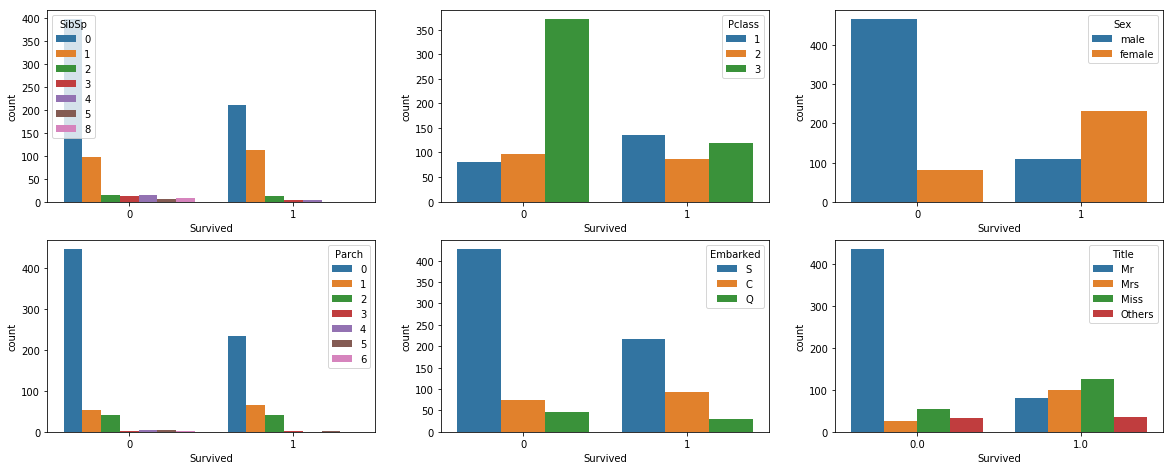

In [75]:
# Create Multiple charts to find the relationship between predictive feature with independent features.
plt.figure (figsize=(20,12))
plt.subplot(331)
sns.countplot (x='Survived', hue='SibSp',data=TitanicDataTr)

plt.subplot(332)
sns.countplot (x='Survived', hue='Pclass',data=TitanicDataTr)

plt.subplot(333)
sns.countplot (x='Survived', hue='Sex',data=TitanicDataTr)

plt.subplot(334)
sns.countplot (x='Survived', hue='Parch',data=TitanicDataTr)

plt.subplot(335)
sns.countplot (x='Survived', hue='Embarked',data=TitanicDataTr)

plt.subplot(336)
sns.countplot (x='Survived', hue='Title',data=TitanicData)

In [76]:
# Filling Missing values in age based on title.
TitanicData.Title = TitanicData.Title.str.replace(' ', '')
TitanicData['Age_Imputed']=TitanicData.groupby(['Title'])['Age']\
    .transform(lambda x: x.fillna(round(x.median(),2)))

TitanicData['Age']=TitanicData['Age_Imputed']
TitanicData.drop(['Age_Imputed'],axis=1,inplace=True)

TitanicDataTrain=TitanicData[~TitanicData.Survived.isnull()]
TitanicDataTest=TitanicData[TitanicData.Survived.isnull()]

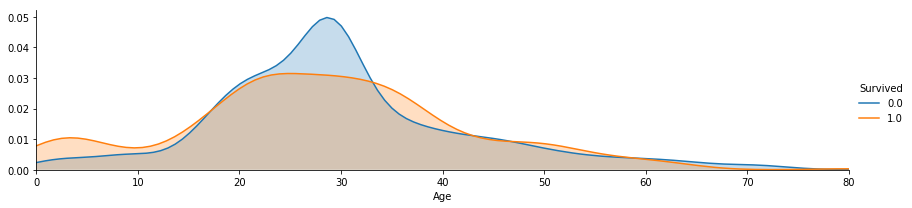

In [77]:
# Check the change probability of survived with respect to age.
Facet= sns.FacetGrid(TitanicDataTrain,hue="Survived", aspect=4)
Facet.map(sns.kdeplot,'Age',shade=True)
Facet.set(xlim=(0,TitanicDataTrain['Age'].max()))
Facet.add_legend()

In [78]:
# Fucntion to create bins.
def Assign_Bins(Value,Complete_list):
    for i in range (0,len(Complete_list)-1):
        if (Value > Complete_list[i] and Value <= Complete_list[i+1]):
            return i

def Create_Bins(df_in,column, bin_list):
    InitialValue = [-1 if 0 < df_in[column].min() else df_in[column].min()-1]
    bin_list.sort()
    LastValue = [bin_list[len(bin_list)-1]+1 if bin_list[len(bin_list)-1] > df_in[column].max() else df_in[column].max()+1]
    CompleteList= InitialValue + bin_list + LastValue
    df_in[column]=df_in[column].apply(lambda x : Assign_Bins(x,CompleteList))        
    return df_in
    
bin_list =[16,26,36,44,48,59]
TitanicData = Create_Bins(TitanicData,"Age",bin_list)

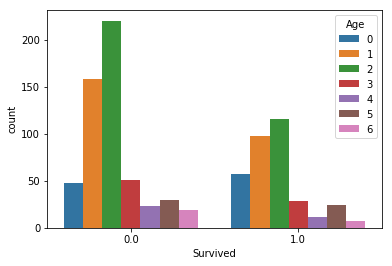

In [79]:
# check how the binned age looks with respect to predictive feature.
TitanicDataTrain=TitanicData[~TitanicData.Survived.isnull()]
TitanicDataTest=TitanicData[TitanicData.Survived.isnull()]

sns.countplot (x='Survived', hue='Age',data=TitanicData)

In [80]:
# Fill Embarked missing value with most used value.
TitanicData['Embarked'].fillna(TitanicData['Embarked'].value_counts().index[0],inplace=True)

In [81]:
# Fill Fare based on class. As it makes sense that fare is depened on class.
TitanicData['Fare'].fillna(TitanicData.groupby("Pclass")['Fare'].transform("median"),inplace=True)

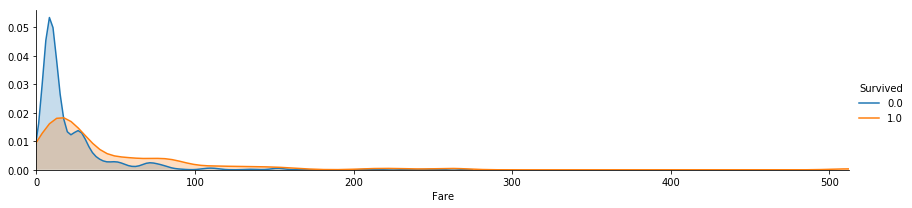

In [82]:
# Relationship between fare and survived feature
Facet= sns.FacetGrid(TitanicDataTrain,hue="Survived", aspect=4)
Facet.map(sns.kdeplot,'Fare',shade=True)
Facet.set(xlim=(0,TitanicDataTrain['Fare'].max()))
Facet.add_legend()

In [83]:
# Create bins for fare.
bin_list =[17,28,100]
TitanicData = Create_Bins(TitanicData,"Fare",bin_list)

In [84]:
# Take first character of Cabin to fill missing values
TitanicData["Cabin"]=TitanicData["Cabin"].str[0]

CatList=TitanicData["Cabin"].unique().tolist()
CatList=[x for x in CatList if str(x) != 'nan']
CatList.sort()
CatMap={k: v for v, k in enumerate(CatList)}
TitanicData["Cabin"]=TitanicData["Cabin"].map(CatMap)

In [85]:
# It makes sense that cabin may depeneds on class.
TitanicData["Cabin"].fillna(TitanicData.groupby("Pclass")["Cabin"].transform("median"), inplace=True)
TitanicData.Cabin = TitanicData.Cabin.astype(int)

TitanicDataTrain=TitanicData[~TitanicData.Survived.isnull()]
TitanicDataTest=TitanicData[TitanicData.Survived.isnull()]

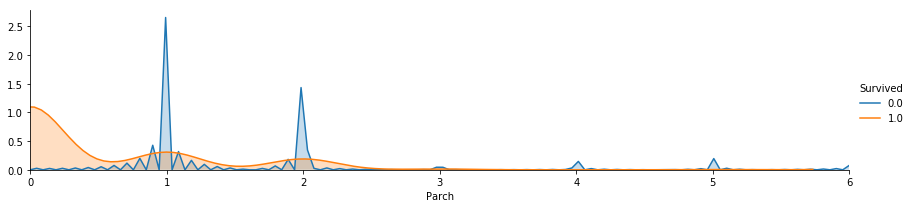

In [86]:
# Change in Survived varibale with respect to number of parent child
Facet= sns.FacetGrid(TitanicDataTrain,hue="Survived", aspect=4)
Facet.map(sns.kdeplot,'Parch',shade=True)
Facet.set(xlim=(0,TitanicDataTrain['Parch'].max()))
Facet.add_legend()

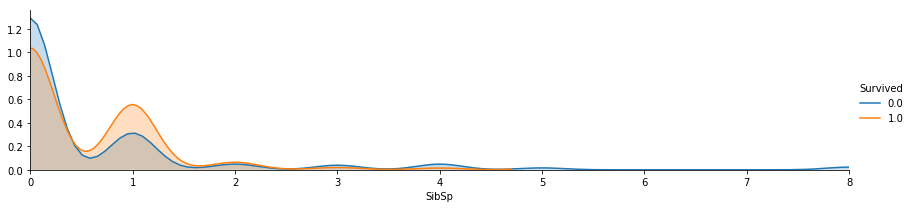

In [87]:
# Change in Survived varibale with respect to number of Sibling spouse.
Facet= sns.FacetGrid(TitanicDataTrain,hue="Survived", aspect=4)
Facet.map(sns.kdeplot,'SibSp',shade=True)
Facet.set(xlim=(0,TitanicDataTrain['SibSp'].max()))
Facet.add_legend()

In [88]:
# perfomring one hot encoding.
TitanicData['Parch']=TitanicData['Parch'].apply(lambda x: 0 if x==0 else 1)
TitanicData['SibSp']=TitanicData['SibSp'].apply(lambda x: 0 if x<=2 else 1)

In [89]:
# Drop name and ticket as they are of no use.
TitanicData.drop(['Name','Ticket'],axis=1,inplace=True)

In [90]:
# perfomring one hot encoding.
gender = {'male': 0,'female': 1} 
TitanicData["Sex"]=TitanicData["Sex"].map(gender)

In [91]:
# Assigning numerical values to feature
CatList=TitanicData["Title"].unique().tolist()
CatList=[x for x in CatList if str(x) != 'nan']
CatList.sort()
CatMap={k: v for v, k in enumerate(CatList)}
TitanicData["Title"]=TitanicData["Title"].map(CatMap)

In [92]:
# Assigning numerical values to feature
CatList=TitanicData["Embarked"].unique().tolist()
CatList=[x for x in CatList if str(x) != 'nan']
CatList.sort()
CatMap={k: v for v, k in enumerate(CatList)}
TitanicData["Embarked"]=TitanicData["Embarked"].map(CatMap)

In [93]:
TitanicData.set_index('PassengerId',inplace=True)

In [95]:
TitanicDataTest=TitanicData[TitanicData.Survived.isnull()]
TitanicDataTrain=TitanicData[~TitanicData.Survived.isnull()]

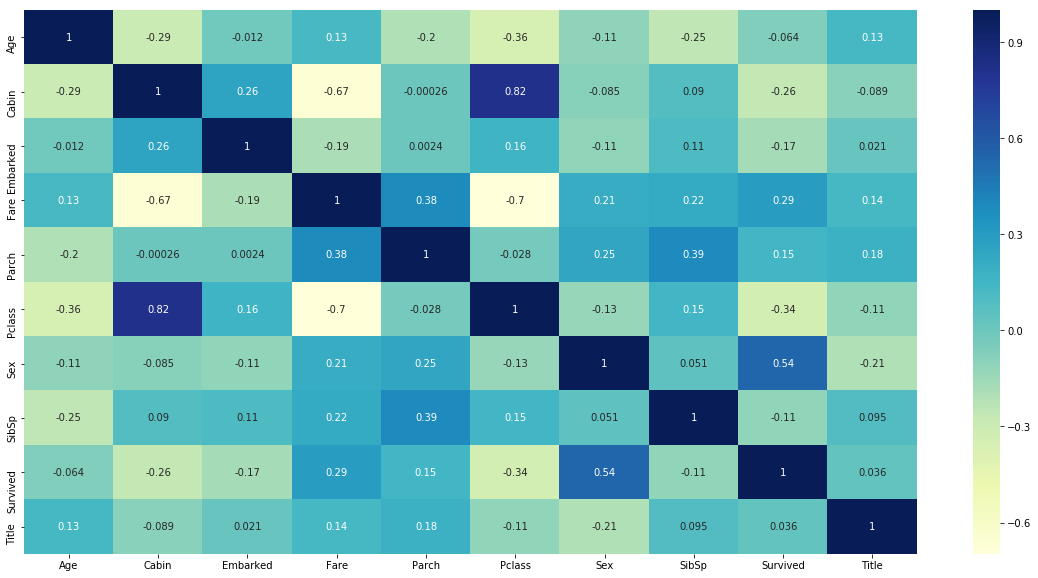

In [96]:
# we will plot a heatmap to look at the corelation in numerical form.
plt.figure(figsize=(20,10))
sns.heatmap(TitanicDataTrain.corr(),annot=True, cmap='YlGnBu')
plt.show()

In [97]:
# Dividing data for modelling
y_train=TitanicDataTrain['Survived']
X_train=TitanicDataTrain[list(TitanicDataTrain.columns[~(TitanicDataTrain.columns == 'Survived')])]

In [98]:
# perfoming standard scaling.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
ColumnListScale= ['Age','Cabin','Embarked','Fare','Pclass','Title']
X_train[ColumnListScale] = scaler.fit_transform(X_train[ColumnListScale])

In [99]:
# importing statsmodel api for better summary analysis.
import statsmodels.api as sm

In [100]:
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      881
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -379.47
Date:                Sun, 12 May 2019   Deviance:                       758.93
Time:                        08:36:20   Pearson chi2:                     930.
No. Iterations:                     5   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5596      0.134    -11.625      0.000      -1.823      -1.297
Age           -0.5730      0.109     -5.261      0.000      -0.786      -0.360
Cabin          0.0367      0.157      0.234      0.815      -0.271       0.344
Embarked      -0.1802      0.094     -1.908      0.056      -0.365       0.005
Fare           0.0460      0.156      0.295      0.768      -0.259       0.351
Parch         -0.1400      0.270     -0.519      0.604      -0.669       0.389
Pclass        -0.9310      0.179     -5.188      0.000      -1.283      -0.579
Sex            2.9596      0.220     13.457      0.000       2.529       3.391
SibSp         -1.8929      0.509     -3.719      0.000      -2.890      -0.895
Title          0.4670      0.099      4.697      0.000       0.272       0.662
==============================================================================
"""

In [101]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,Pclass,4.12
1,Cabin,3.40
3,Fare,2.97
4,Parch,1.86
7,SibSp,1.47
6,Sex,1.43
0,Age,1.25
8,Title,1.16
2,Embarked,1.12


In [102]:
# We will consider only columns with less Varience and p values less than 0.05.
y_train=TitanicDataTrain['Survived']
X_train=TitanicDataTrain[list(TitanicDataTrain.columns[(TitanicDataTrain.columns != 'Cabin') & 
                                                         (TitanicDataTrain.columns != 'Fare') &
                                                        (TitanicDataTrain.columns != 'Parch') &
                                                      (TitanicDataTrain.columns != 'Survived')])]
X_train_c=sm.add_constant(X_train)
logm1 = sm.GLM(y_train,X_train_c, family = sm.families.Binomial())
res=logm1.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      884
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -379.62
Date:                Sun, 12 May 2019   Deviance:                       759.23
Time:                        08:36:20   Pearson chi2:                     934.
No. Iterations:                     5   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4824      0.407      3.645      0.000       0.685       2.280
Age           -0.3969      0.075     -5.323      0.000      -0.543      -0.251
Embarked      -0.2235      0.115     -1.946      0.052      -0.449       0.002
Pclass        -1.1113      0.126     -8.826      0.000      -1.358      -0.864
Sex            2.9332      0.208     14.097      0.000       2.525       3.341
SibSp         -1.9199      0.471     -4.076      0.000      -2.843      -0.997
Title          0.5648      0.116      4.884      0.000       0.338       0.791
==============================================================================
"""

In [103]:
# Perfom the prediction on train data.
y_train_pred = res.predict(X_train_c)
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred_final = pd.DataFrame({'Survived':y_train.values, 'Survived_Prob':y_train_pred})
y_train_pred_final['PassengerId'] = y_train.index

In [106]:
# Setting the cutoff to 0.5 probablity for survived or not.
y_train_pred_final['predicted'] = y_train_pred_final.Survived_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Survived,Survived_Prob,PassengerId,predicted
0,0.0,0.106162,1,0
1,1.0,0.962428,2,1
2,1.0,0.559179,3,1
3,1.0,0.960572,4,1
4,0.0,0.073952,5,0


In [107]:
# Building confusion matix.
from sklearn import metrics

# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Survived, y_train_pred_final.predicted )
print(confusion)

[[468  81]
 [ 92 250]]


In [108]:
print("Accuracy of model:", round(metrics.accuracy_score(y_train_pred_final.Survived, y_train_pred_final.predicted),2))

Accuracy of model: 0.81


In [109]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Survived_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Survived,Survived_Prob,PassengerId,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.0,0.106162,1,0,1,1,0,0,0,0,0,0,0,0
1,1.0,0.962428,2,1,1,1,1,1,1,1,1,1,1,1
2,1.0,0.559179,3,1,1,1,1,1,1,1,0,0,0,0
3,1.0,0.960572,4,1,1,1,1,1,1,1,1,1,1,1
4,0.0,0.073952,5,0,1,0,0,0,0,0,0,0,0,0


In [110]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy'])
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Survived, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    cutoff_df.loc[i] =[ i ,accuracy]
print(cutoff_df)

     prob  accuracy
0.0   0.0  0.383838
0.1   0.1  0.569024
0.2   0.2  0.751964
0.3   0.3  0.804714
0.4   0.4  0.806958
0.5   0.5  0.805836
0.6   0.6  0.820426
0.7   0.7  0.801347
0.8   0.8  0.760943
0.9   0.9  0.702581


In [111]:
# Check the accuracy of model
y_train_pred_final['final_predicted'] = y_train_pred_final.Survived_Prob.map( lambda x: 1 if x > 0.5 else 0)
round(metrics.accuracy_score(y_train_pred_final.Survived, y_train_pred_final.final_predicted)*100,2)

80.58

In [112]:
X_test=TitanicDataTest.drop(["Survived"],axis=1)
X_test[ColumnListScale] = scaler.transform(X_test[ColumnListScale])

In [113]:
X_test=TitanicDataTest[list(TitanicDataTest.columns[(TitanicDataTest.columns != 'Cabin') & 
                                                         (TitanicDataTest.columns != 'Fare') &
                                                        (TitanicDataTest.columns != 'Parch') &
                                                      (TitanicDataTest.columns != 'Survived')])]

X_test_sm = sm.add_constant(X_test)

In [114]:
y_test_pred = res.predict(X_test_sm)

y_test_df = pd.DataFrame(y_test_pred)

# Putting CustID to index
y_test_df['PassengerId'] = y_test_df.index
y_test_df.reset_index(drop=True, inplace=True)

y_test_df= y_test_df.rename(columns={ 0 : 'Survived_Prob'})

y_test_df['Survived'] = y_test_df.Survived_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_test_df.drop(['Survived_Prob'],axis=1,inplace=True)

In [115]:
y_test_df.to_csv("New_Result.csv",index=False)

In [116]:
# Checking accuracy based on different classifier models.
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10,shuffle=True, random_state=0)

In [117]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors = 6)
scoring = "accuracy"
score =cross_val_score(clf,X_train,y_train,cv=k_fold,n_jobs=1, scoring=scoring)
print(round(np.mean(score)*100,2))

82.27


In [118]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
scoring = "accuracy"
score =cross_val_score(clf,X_train,y_train,cv=k_fold,n_jobs=1, scoring=scoring)
print(round(np.mean(score)*100,2))

81.94


In [119]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
scoring = "accuracy"
score =cross_val_score(clf,X_train,y_train,cv=k_fold,n_jobs=1, scoring=scoring)
print(round(np.mean(score)*100,2))

81.15


In [120]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
scoring = "accuracy"
score =cross_val_score(clf,X_train,y_train,cv=k_fold,n_jobs=1, scoring=scoring)
print(round(np.mean(score)*100,2))

79.68


In [121]:
from sklearn.svm import SVC

clf = SVC()
scoring = "accuracy"
score =cross_val_score(clf,X_train,y_train,cv=k_fold,n_jobs=1, scoring=scoring)
print(round(np.mean(score)*100,2))

82.6


In [129]:
# clf = SVC()
# clf.fit(X_train,y_train)
# y_test_pred=clf.predict(X_test)
# y_test_df = pd.DataFrame({"PassengerID": X_test.index, "Survived": y_test_pred})
# y_test_df['Survived'] = y_test_df['Survived'].astype(int)

,PassengerID,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [131]:
# y_test_df.to_csv("New_Result.csv",index=False)